# Assumptions:
- In this exercise, I would focus on applying demand forecast model to specific product with the most extensive data i.e. available data across longer time period. 
- It is possible to do demand forecast model for an aggregated products by category, collection index of even family index but given lack of contextual knowledge, I will assume that forecasting can be reasonably done on one single product.

In [15]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import sys

from scipy import stats

In [26]:
# Read the raw file
raw_file = "Q2 Demand Forecast.csv"
df_raw = pd.read_csv(raw_file)
df_raw.shape

(13862, 10)

In [27]:
# Remove any rows with null values
df = df_raw.dropna()
df.shape

(13648, 10)

In [28]:
# Remove any rows with null values
df = df_raw.dropna()
df.shape

def get_unique_product_id(row):
    return str(row["sku_index"]) + "_" + str(row["sku_family_index"]) + "_" + str(row["collection_index"])

def get_month_year(row):
    return str(row["order_month"].month) + "_" + str(row["order_month"].year)

df["product_id"] = df.apply(get_unique_product_id, axis=1)

df['order_month'] = pd.to_datetime(df['order_month'])

df["month_year"] = df.apply(get_month_year, axis=1)

/var/folders/4_/w_mf839j0j13gflnpzsq5pn80000gn/T/ipykernel_80925/2818647569.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["product_id"] = df.apply(get_unique_product_id, axis=1)
/var/folders/4_/w_mf839j0j13gflnpzsq5pn80000gn/T/ipykernel_80925/2818647569.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_month'] = pd.to_datetime(df['order_month'])
/var/folders/4_/w_mf839j0j13gflnpzsq5pn80000gn/T/ipykernel_80925/2818647569.py:13: SettingWithCopyWarning: 
A value is trying to be set on a co

In [29]:
len(df["month_year"].unique())

24

In [30]:
def compute_monthly_agg_sku(df_product):
    
    df_product = df[df["product_id"] == product_id]
    
    
    agg_sku_by_month = {}
    
    for idx, row in df_product.iterrows():
        month = row["month_year"]
        if month not in agg_sku_by_month.keys():
            agg_sku_by_month[month] = 0
        agg_sku_by_month[month] += row['sku_qty']
        
    return agg_sku_by_month
        

In [31]:
# Get the product with the most extensive time-series data

product_id_list = df["product_id"].unique()

product_master_data = {}

for product_id in product_id_list:
    df_product = df[df["product_id"] == product_id]
    agg_data = compute_monthly_agg_sku(df_product)
    product_master_data[product_id] = agg_data
    

max_month = 0
max_product_id = ""

for product_id in product_master_data.keys():
    numMonths = len(product_master_data[product_id].keys())
    if numMonths > max_month:
        max_month = numMonths
        max_product_id = product_id
        
print(max_product_id, max_month)
    

3_3_3 24


In [260]:
df_product = df[df['product_id'] == max_product_id]
df_product.set_index("order_month", inplace=True)

In [261]:
df_product.shape

(24, 11)

# Demand Forecast Using ARIMA

In [34]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [125]:
train_data = df_product["sku_qty"][:12]
test_data = df_product["sku_qty"][11:]

In [127]:
history = [x for x in train_data]
y = test_data
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit()
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])

In [66]:
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)

[17.253072363608144]

## Performance Metrics

In [129]:
# report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

MSE: 124.33900237230857
MAE: 8.552126853105552
RMSE: 11.15073999213992


## Plot the Output

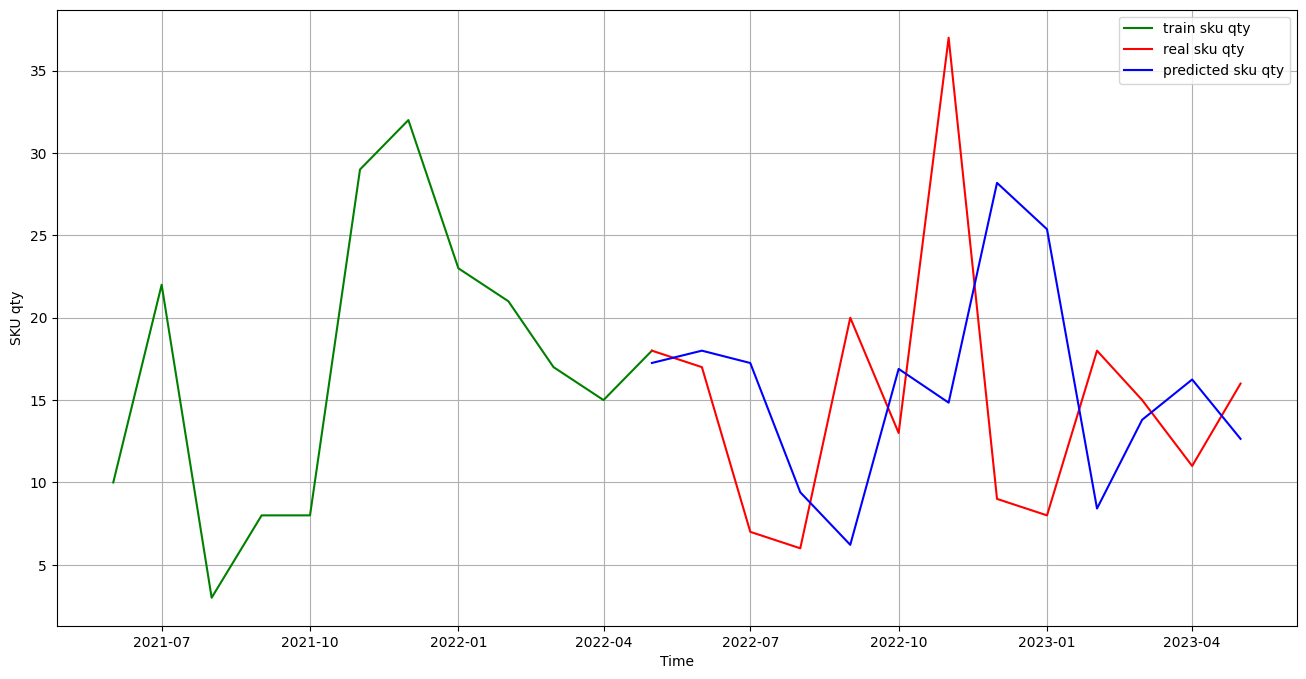

In [130]:
plt.figure(figsize=(16,8))
plt.plot(train_data.index, train_data, color='green', label = 'train sku qty')
plt.plot(test_data.index, y, color = 'red', label = 'real sku qty')
plt.plot(test_data.index, predictions, color = 'blue', label = 'predicted sku qty')

plt.xlabel('Time')
plt.ylabel('SKU qty')
plt.legend()
plt.grid(True)

plt.show()

# Demand Forecast using Pytorch Forecasting

In [262]:
import pandas as pd
import torch
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting.metrics import SMAPE, MultivariateNormalDistributionLoss

In [263]:
# Preparing data set
train_data = df_product

In [266]:
train_data.reset_index(inplace=True)
train_data.drop(columns=['sku_index', 'sku_family_index', 'collection_index',
       'category', 'is_online_1st_day',
       'month_year', 'lead_time_1st_day', 'original_price_1st_day', 'sale_price_1st_day'],inplace=True)
train_data['time_idx'] = train_data.index

/var/folders/4_/w_mf839j0j13gflnpzsq5pn80000gn/T/ipykernel_80925/1348274010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(columns=['sku_index', 'sku_family_index', 'collection_index',
/var/folders/4_/w_mf839j0j13gflnpzsq5pn80000gn/T/ipykernel_80925/1348274010.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['time_idx'] = train_data.index


In [268]:
train_data.head()

,order_month,sku_qty,product_id,time_idx
0,2021-06-01,10.0,3_3_3,0
1,2021-07-01,22.0,3_3_3,1
2,2021-08-01,3.0,3_3_3,2
3,2021-09-01,8.0,3_3_3,3
4,2021-10-01,8.0,3_3_3,4


In [269]:
max_encoder_length = 12 # days
max_prediction_length = 12 # 20 days
training_cutoff = train_data["time_idx"].max() - max_prediction_length

In [270]:
# Create a time series dataset
training = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",
    target="sku_qty",
    group_ids=["product_id"], # list of column names identifying a time series.
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["product_id"], # categorical variables that do not change over time (e.g. product categories)
    time_varying_unknown_reals=['sku_qty'],
)

In [271]:
# Create validation dataset
validation = TimeSeriesDataSet.from_dataset(training, train_data, min_prediction_idx=training_cutoff + 1)

In [272]:
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0
)

In [273]:
pl.seed_everything(42)

Seed set to 42


42

In [274]:
trainer = pl.Trainer(
    gradient_clip_val=0.1,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [275]:
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=30)
)

/Users/waldyjoe/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/waldyjoe/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [276]:
trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

/Users/waldyjoe/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.5 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.5 K    Trainable params
0         Non-trainable params
12.5 K    Total params
0.050     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/waldyjoe/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


AssertionError: MPS accelerator has a bug https://github.com/pytorch/pytorch/issues/98074, use cpu or gpu